In [1]:
import pandas as pd
import datetime as dt

# Loading the raw transaction data. 
# It's important to use the original excel export from the store's database.
df = pd.read_excel('Online Retail.xlsx')

# Quick look to verify the structure and column names
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [2]:
# Removing rows without a CustomerID since they can't be assigned to a segment.
df = df.dropna(subset=['CustomerID'])

# Filtering out negative quantities (returns/cancellations) 
# to ensure we calculate actual revenue, not gross sales.
df = df[df['Quantity'] > 0]

# Creating the 'TotalSum' column for Monetary Value calculation.
df['TotalSum'] = df['Quantity'] * df['UnitPrice']

print(f"Data cleaned. Proceeding with {len(df)} valid transaction records.")

Data cleaned. Proceeding with 397924 valid transaction records.


In [3]:
# To calculate Recency, we set a 'reference date' (one day after the last purchase).
# This ensures even the most recent customers have a Recency of at least 1 day.
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Aggregating transactions at the customer level.
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'
})

# Renaming for clarity before the scoring phase.
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalSum': 'MonetaryValue'
}, inplace=True)

rfm.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


In [4]:
# Ranking customers by dividing them into four equal groups (quartiles).
# Note: For Recency, a lower number of days is better, so the labels are reversed.
rfm['R'] = pd.qcut(rfm['Recency'], q=4, labels=[4, 3, 2, 1])
rfm['F'] = pd.qcut(rfm['Frequency'], q=4, labels=[1, 2, 3, 4])
rfm['M'] = pd.qcut(rfm['MonetaryValue'], q=4, labels=[1, 2, 3, 4])

# Summing up the scores to get a final RFM index.
# This helps us rank customers from 3 to 12.
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis=1)

print("Scoring completed. Every customer now has a unique rank based on their behavior.")
rfm.head()

Scoring completed. Every customer now has a unique rank based on their behavior.


,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score
CustomerID,,,,,,,
12346.0,326,1,77183.60,1,1,4,6
12347.0,2,182,4310.00,4,4,4,12
12348.0,75,31,1797.24,2,2,4,8
12349.0,19,73,1757.55,3,3,4,10
12350.0,310,17,334.40,1,1,2,4


In [5]:
# Defining customer groups based on their total RFM score.
# This logic focuses on distinguishing top performers from those needing retention efforts.
def assign_segment(score):
    if score >= 10:
        return 'VIP (Champions)'
    elif score >= 6:
        return 'Loyal (Regulars)'
    else:
        return 'At Risk (Hibernating)'

# Applying the segments to the dataset
rfm['Segment'] = rfm['RFM_Score'].apply(assign_segment)

# Reviewing the results: How many customers fall into each category?
print("Market Segmentation Overview:")
print(rfm['Segment'].value_counts())

rfm.head()

Market Segmentation Overview:
Segment
Loyal (Regulars)         1791
At Risk (Hibernating)    1283
VIP (Champions)          1265
Name: count, dtype: int64


,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score,Segment
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,4,6,Loyal (Regulars)
12347.0,2,182,4310.00,4,4,4,12,VIP (Champions)
12348.0,75,31,1797.24,2,2,4,8,Loyal (Regulars)
12349.0,19,73,1757.55,3,3,4,10,VIP (Champions)
12350.0,310,17,334.40,1,1,2,4,At Risk (Hibernating)


In [8]:
# Exporting the final results to Excel. 
# This file is ready to be shared with the marketing team or uploaded to an email platform.
rfm.to_excel('Customer_Segmentation_Results.xlsx')

print("✅ Success! The 'Customer_Segmentation_Results.xlsx' file is ready for delivery.")

✅ Success! The 'Customer_Segmentation_Results.xlsx' file is ready for delivery.


C:\Users\eleni\AppData\Local\Temp\ipykernel_16056\223280211.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='Segment', palette='viridis', order=segment_order)


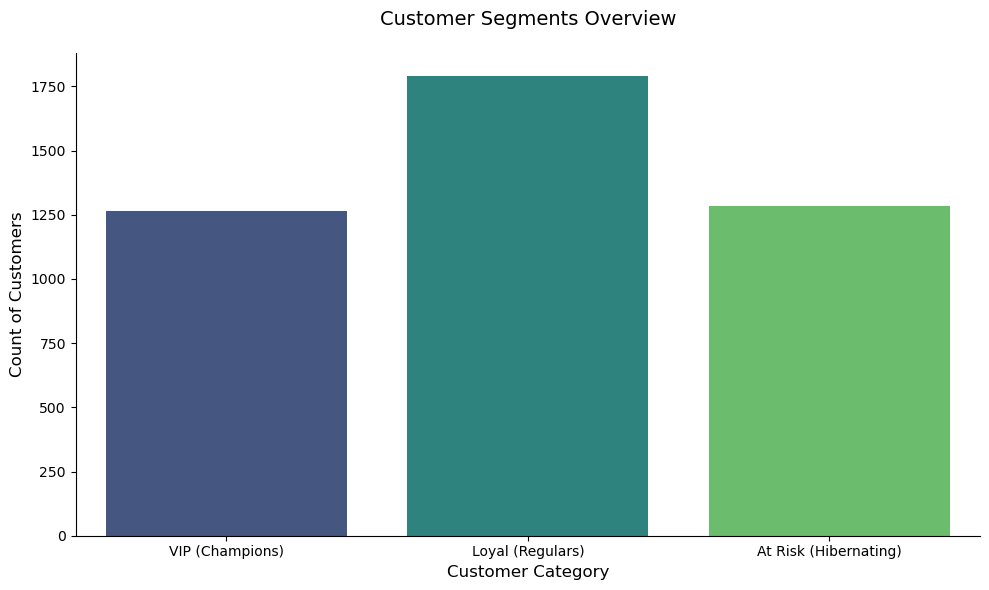

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizing the distribution of customer segments.
# This chart is the 'elevator pitch' of the analysis - it shows the health of the customer base at a glance.
plt.figure(figsize=(10, 6))

# We use a professional color palette and set a logical order for the segments.
# This makes it easier for a business owner to interpret the scale of each group.
segment_order = ['VIP (Champions)', 'Loyal (Regulars)', 'At Risk (Hibernating)']
sns.countplot(data=rfm, x='Segment', palette='viridis', order=segment_order)

# Adding clear, non-technical titles.
plt.title('Customer Segments Overview', fontsize=14, pad=20)
plt.xlabel('Customer Category', fontsize=12)
plt.ylabel('Count of Customers', fontsize=12)

# Removing unnecessary chart borders for a cleaner, modern look.
sns.despine()

plt.tight_layout()
plt.show()